In [3]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import gzip
import os
import pandas as pd
import scipy
#from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
OUTDIR = "pdfs/"

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to generate the following results from Zheng et al 2020:

* ED Figure 6a-c: QQ plots for factor/trait combinations
* ED Figure 6e,f,g: QQ plot stratify by GCAM score
* ED Figure 6e: GWAS example for WBC

# ED Figure 6a-c QQ plots for factor/trait combinations

In [10]:
#DIR="/storage/pandaman/project/singletons/AgentBind/"
DIR = "/gymreklab-tscc/pandaman/AgentBind-research-results-IMPORTANT/singletons/AgentBind"

factors = ["CTCF","EBF1","SP1","PU1","RUNX3","NFYB","Nrf1","ELF1","NFKB","TCF3"]
factors_to_plot = factors 
f2c = {
    "SP1": "red",
    "CTCF": "orange",
    "EBF1": "yellow",
    "PU1": "green",
    "RUNX3": "blue",
    "NFYB": "purple",
    "Nrf1": "violet",
    "ELF1": "magenta",
    "NFKB": "cyan",
    "TCF3": "brown"
}

trait_to_gwas = {
    "WBC": "/storage/pandaman/project/GWAS/wbc_N172435_narrow_form.tsv.gz",
    "RBC": "/storage/mgymrek/agent-bind/gwas/summstats/RBC_N172952_summ.tab",
    "IBD": "/storage/mgymrek/agent-bind/gwas/summstats/EUR.IBD_summ.tab"
}

# Load scores for SNPs for each factor
factordata = {}
for f in factors:
    print (f)
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "scores.tab"), sep="\t", skiprows=1,
                            names=["chrom","start","raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata

CTCF
EBF1
SP1
PU1
RUNX3
NFYB
Nrf1
ELF1
NFKB
TCF3


In [ ]:
# Perform trait-specific analysis
for trait in ["WBC", "RBC", "IBD"]:

    # Load GWAS data for the trait of interest
    gwas = pd.read_csv(trait_to_gwas[trait], sep="\t")
    gwas["CHR"] = gwas["CHR"].apply(lambda x: "chr"+str(x))
    gwas["BP"] = gwas["BP"].apply(lambda x: x-1)
    gwas = gwas.rename(columns={"CHR": "chrom", "BP": "start"})

    # Merge with GWAS data
    gwd = {}
    for f in factors:
        fd = factordata[f]
        fd["chrom"] = fd["chrom"].apply(str)
        merged_df = pd.merge(fd, gwas, on=["chrom","start"])
        merged_df = merged_df[((merged_df["REF"]).str.len() == 1) & ((merged_df["ALT"]).str.len() == 1)]
        merged_df = merged_df.sort_values("rank", ascending=False)
        merged_df = merged_df.drop_duplicates(subset=["chrom", "start"], keep='first')
        gwd[f] = merged_df
        
    ####### Plot multiple TFs (a-c) #####
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("expected", size=15)
    ax.set_ylabel("observed", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 3.5), (0, 30))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    
    s_random = [-log10(random.random()) for _ in range(int(10e6))]
    for f in f2c.keys():
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        y_points_ab = sorted(s_high_scored_ab.values.tolist())        
        x_points = sorted(s_random[:high_scored_ab.shape[0]])     
        ax.scatter(x_points, y_points_ab,  s=5, c=f2c[f], label=f)
    if trait == "IBD": ax.legend(loc="upper left")
    fig.savefig(os.path.join(OUTDIR, "AgentBind-MultiFactor-%s.png"%trait))
    
    ####### Plot multiple TFs (a-c) #####
    if trait == "WBC":
        f = "SP1"
    if trait == "RBC":
        f = "Nrf1"
    if trait == "IBD":
        f = "NFKB"
        
    high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[0]]
    high_scored_ab_ext = gwd[f][gwd[f]["rank"] >= rank_perc[1]]

    # control - same MA_FREQ distribution
    dist, _ = np.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
    control_list = []
    control_list_all = []
    for bin_index in range(len(bins)-1):
        lower, upper = bins[bin_index], bins[bin_index + 1]
        n_samples = dist[bin_index]
        control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
        control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
    control = pd.concat(control_list)
    control_all = pd.concat(control_list_all)
        
    s_high_scored_ab = high_scored_ab["MLOG10P"]
    s_high_scored_ab_ext = high_scored_ab_ext["MLOG10P"]
    s_ct = control["MLOG10P"]
    s_ct_all = control_all["MLOG10P"]

    s_random = [-log10(random.random()) for _ in range(high_scored_ab.shape[0])]
    s_random_ext = s_random[:high_scored_ab_ext.shape[0]]
        
    y_points_ab = sorted(s_high_scored_ab.values.tolist())
    y_points_ab_ext = sorted(s_high_scored_ab_ext.values.tolist())
    y_points_ct = sorted(s_ct.values.tolist())
    y_points_ct_all = sorted(s_ct_all.values.tolist())
    x_points = sorted(s_random)
    x_points_ext = sorted(s_random_ext)
        
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    line_ct_all = ax.scatter(x_points, y_points_ct_all, c="grey", s=10)
    line_ct = ax.scatter(x_points, y_points_ct, c="k", s=10)
    line_ab = ax.scatter(x_points, y_points_ab, c="orange", s=10)
    #ax.scatter(x_points_ext, y_points_ab_ext, c="red", s=10)
    ax.set_xlabel("$-log_{10} P (expected)$", size=15)
    ax.set_ylabel("$-log_{10} P (observed)$", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 4.5), (0, 90))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.legend([line_ab, line_ct, line_ct_all],
              ["Top 5% GradCAM (%s)"%factor, "All context (%s)"%factor, "Genome-wide"],
              loc="upper left", frameon=False)
    fig.savefig(os.path.join(OUTDIR, "GWAS_%s_%s.pdf"%(f, trait)))

# ED Figure 6e - GWAS Example for WBC

In [4]:
# Paths
COREDIR = "/storage/pandaman/project/AgentBind-GM12878-DanQ-unfixed-rnn-trans/storage/AgentBind-GM12878-DanQ/tmp/"

# Data for the hit
#chrom = "chr6"; pos = 31535454 # LTA, TNF region lots of info on this one
#chrom="chr3"; pos=101498076; # NXPE3
chrom="chr2"; pos=143886818; # ARHGAP15 #https://ashpublications.org/blood/article/118/4/1099/28906/The-RacGAP-ArhGAP15-is-a-master-negative-regulator
factor = "SP1"
gwasfile = "/storage/mgymrek/agent-bind/gwas-round2/indexed-data/wbc_summstats.bed.gz"

# Data files
maskfile = os.path.join(COREDIR, "%s+GM12878"%factor, "seqs_one_hot_b/vis-weights-total/weight.txt")

WINDOW = 1000000 # 100000
def LoadGWAS(gwasfile, usechrom, usepos, WINDOW):
    pos = []
    pval = []
    rsid = []
    with gzip.open(gwasfile, "rt") as f:
        for line in f:
            items = line.strip().split()
            chrom = items[0]
            start = int(items[1])
            p = float(items[4])
            rs = items[3]
            if chrom!=usechrom: continue
            if usepos > start-WINDOW and usepos < start+WINDOW:
                pos.append(start)
                pval.append(p)
                rsid.append(rs)
    return pd.DataFrame({"pos": pos, "rsid": rsid, "pval": pval})
gwasdata = LoadGWAS(gwasfile, chrom, pos, WINDOW)

In [6]:
# chr7;38217660;38217671;38217166;38218166;+
#chr10;99078951;99078962;99078457;99079457;+
def LoadScores(weightfile, usechrom, usepos):
    f = open(weightfile, "r")
    locline = f.readline()
    wline = f.readline()
    ASIZE = 1000
    pos = [None]*ASIZE
    while locline.strip() != "":
        locitems = locline.split(";")
        chrom = locitems[0]
        start = int(locitems[3])
        end = int(locitems[4])
        if not ((chrom == usechrom) and (usepos>=start) and (usepos<=end)):
            locline = f.readline()
            wline = f.readline()
            continue
        print(locline)
        # Parse weights
        weights = [max([0, float(item)]) for item in wline.strip().split(";")]
        # Update weights and pos
        pos = list(range(start-1, start-1+ASIZE))
        return pd.DataFrame({"pos": pos, "weight": weights})
        locline = f.readline()
        wline = f.readline()
    return None

scoredata = LoadScores(maskfile, chrom, pos)

chr2;143886878;143886889;143886384;143887384;+



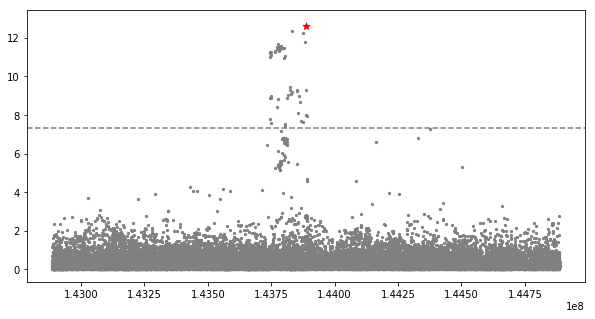

In [7]:
data = pd.merge(scoredata, gwasdata, on=["pos"], how="outer").sort_values("pos")
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.scatter(data["pos"], data["pval"].apply(lambda x: -1*np.log10(x)), color="gray", s=5)
ax.axhline(y=-1*np.log10(5*10**-8), linestyle="dashed", color="gray")

hit = data[data["pos"]==pos+1]
ax.scatter(hit["pos"], hit["pval"].apply(lambda x: -1*np.log10(x)), color="red", marker="*", s=50)

fig.savefig(os.path.join(OUTDIR, "GWASExample-ARHGAP15.pdf"))